# Obtendo dados de CNPJ's com a API Minha Receita

Este projeto utiliza Python para fazer requisições à [API Minha Receita](https://docs.minhareceita.org/), uma iniciativa da sociedade civil que disponibiliza, de forma gratuita e acessível, dados da Receita Federal.

Neste tutorial/registro do projeto, veremos:
- Como realizar conexão com PostgreSQL para que o Python possa acessar o conteúdo de um banco de dados;
- Como fazer requisições para a API Minha Receita e obter informações associadas a um CNPJ segundo a Receita Federal;
- Como armazenar a resposta da API em um banco de dados PostgreSQL.

Este projeto foi desenvolvido como parte das atividades do [Instituto Brasileiro de Defesa do Consumidor (Idec)](https://idec.org.br/), que está utilizando dados da [Agência Nacional de Energia Elétrica (ANEEL)](http://aneel.gov.br/) para analisar o perfil socioeconômico dos adotantes de Geração Distribuída no país. Entretanto, o código disponibilizado pode ser utilizado em diversas outras aplicações.

## Conexão com PostgreSQL
Nosso objetivo é fazer requisições à API Minha Receita para obter dados de +46mil CNPJ's. Esses CNPJ's estão armazenados em uma tabela PostgreSQL, por isso, primeiro precisamos realizar a conexão com o banco de dados e fazer com que o Python tenha acesso à lista de CNPJ's.  
  
Para fazer essa conexão, estamos usando a biblioteca [Psycopg](https://www.psycopg.org/docs/), que permite que o Python conecte-se a um banco de dados PostgreSQL. A função `sql_conection()` realiza a conexão e será utilizada em todos os momento em que for necessário interagir com o banco de dados.

In [1]:
import psycopg2
def sql_connection():
    # Realiza a conexão com o banco de dados PostgreSQL e retorna a variável que será utilizada para interagir com o banco
    database = ''
    user = ''
    password = ''
    host = ''
    port = ''
    con = psycopg2.connect(database=database,
                           user=user,
                           password=password,
                           host=host,
                           port=port)
    return con

Nosso banco de dados contém uma tabela com vários dados, entre os quais está o CNPJ dos adotantes de Geração Distribuída. Vamos fazer uma query para essa tabela e armazenar os CNPJ's únicos em um dataframe.

In [3]:
import pandas as pd
import pandas.io.sql as sqlio
def query_to_df(query):
    # Dada uma query PostgreSQL, realiza a query no banco de dados e armazena o resultado em um dataframe
    con = sql_connection()
    data_set = sqlio.read_sql_query(query, con)
    return data_set


query = 'select distinct(cpf_cnpj) from ligacoes_gd lg where length(cpf_cnpj) > 11'
df_cnpj = query_to_df(query)
print('Total de CNPJs únicos:', len(df_cnpj))

Total de CNPJs únicos: 46911


## Fazendo requisições para a API Minha Receita
Por enquanto, temos uma lista com 46.911 CNPJ's, mas não temos nenhuma informação sobre eles. Felizmente, podemos fazer requisições à API Minha Receita e obter informações da Receita Federal sobre cada um desses CNPJ's.  
  
A função `get_cnpj_data(cnpj)` utiliza a biblioteca [Requests](https://requests.readthedocs.io/en/master/) para realizar uma requisição à API, procurando por um CNPJ, e retorna os dados encontrados.

In [5]:
import requests
def get_cnpj_data(cnpj):
    # Dado um CNPJ, faz uma requisição para a API Minha Receita. Caso a requisição seja bem sucedida, retorna o conteúdo da requisição em formato json
    minha_receita_api_url = 'https://minhareceita.org/'
    r = requests.post(minha_receita_api_url, data=cnpj, timeout=None)
    if r.status_code == 200:
        return json.loads(r.content)

Para nos familiarizarmos com a resposta da API, vamos fazer uma requisição de exemplo e utilizar a função `jprint()` para gerar uma visualização amigável do objeto json retornado pela API.

In [18]:
import json
def jprint(obj):
    # Cria visualização amigável de um objeto json
    text = json.dumps(obj, sort_keys=True, indent=4, ensure_ascii=False)
    print(text)


cnpj_example = {'cnpj': 19131243000197}
response_example = get_cnpj_data(cnpj_example)
jprint(response_example)

{
    "bairro": "BELA VISTA",
    "capital_social": 0,
    "cep": "01311902",
    "cnae_fiscal": 9430800,
    "cnae_fiscal_descricao": "Atividades de associações de defesa de direitos sociais",
    "cnaes_secundarias": [
        {
            "codigo": 9493600,
            "descricao": "Atividades de organizações associativas ligadas à cultura e à arte"
        },
        {
            "codigo": 9499500,
            "descricao": "Atividades associativas não especificadas anteriormente"
        },
        {
            "codigo": 8599699,
            "descricao": "Outras atividades de ensino não especificadas anteriormente"
        },
        {
            "codigo": 8230001,
            "descricao": "Serviços de organização de feiras, congressos, exposições e festas"
        },
        {
            "codigo": 6204000,
            "descricao": "Consultoria em tecnologia da informação"
        }
    ],
    "cnpj": "19131243000197",
    "codigo_municipio": 7107,
    "codigo_natureza_juridic

## Obtendo dados de +46mil CNPJ's
Agora que fizemos uma requisição de exemplo e estamos familiarizados com a resposta da API, podemos seguir para a parte divertida e finalmente obter os dados da Receita Federal sobre os 46.911 CNPJ's nos quais estamos interessados.  
  
Primeiro, vamos criar uma tabela PostgreSQL para armazenar nossos dados. Entre todas as informações que retornam da API, escolhemos apenas algumas variáveis principais, que são mais interessantes para as análises futuras.  
  
Utilizamos o método [connection.cursor()](https://www.psycopg.org/docs/cursor.html), que permite que o Python execute comandos em um banco de dados PostgreSQL. Repare que, após executar o comando, é necessário utilizar também o método [connection.commit()](https://www.psycopg.org/docs/connection.html#connection.commit) para garantir que as mudanças no banco de dados sejam feitas.

In [7]:
def create_sql_table():
    # Cria uma tabela PostgreSQL para armazenar os dados dos CNPJ's
    con = sql_connection()
    with con.cursor() as cur:
        create_table_command = 'create table if not exists cnpj_data('\
            'cnpj varchar(100),'\
            'razao_social varchar(250),'\
            'nome_fantasia varchar(250),'\
            'atividade_principal_codigo varchar(50),'\
            'atividade_principal_descricao varchar(1000),'\
            'situacao_cadastral varchar(50),'\
            'capital_social float,'\
            'porte varchar(50),'\
            'codigo_natureza_juridica int,'\
            'data_abertura date,'\
            'cep varchar(50),'\
            'municipio varchar(100),'\
            'uf varchar(2)'\
            ')'
        cur.execute(create_table_command)
        con.commit()
create_sql_table()

Uma vez criada a tabela, podemos começar a alimentá-la com os dados dos CNPJ's. Para isso, vamos considerar a orientação da [documentação do PostgreSQL](https://www.postgresql.org/docs/current/populate.html#POPULATE-COPY-FROM) de que a melhor forma de alimentar uma tabela é usando o comando COPY FROM. Uma demonstração sobre o melhor desempenho do COPY FROM em relação a outros métodos pode ser encontrada [nesta análise](https://hakibenita.com/fast-load-data-python-postgresql), que avalia a performance de diferentes formas de importar dados de uma fonte remota para uma tabela PostgreSQL.

Assim, para alimentar nossa tabela, seguiremos o seguinte fluxo:  
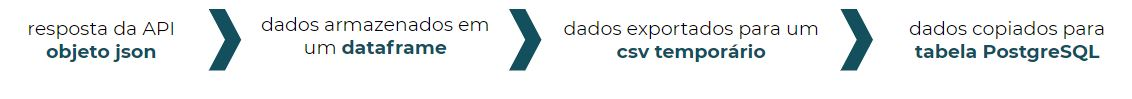  
  
Vamos começar definindo as funções que utilizaremos para armazenar os dados da resposta da API em um dataframe. Repare que, na função `cnpj_data_to_df()`, caso o CNPJ não seja encontrado e a resposta da API volte com valor nulo, iremos adicionar o CNPJ ao dataframe mesmo assim, porém com valores nulos nas colunas de informações. Isso nos ajudará a ter controle sobre quais CNPJ's foram encontrados e quais não foram.

In [8]:
def clean_text(full_text):
    # Limpa um texto, retirando quebras de linha e ponto-e-vírgulas
    clean_text = full_text.replace("\n", " ")
    clean_text = full_text.replace(";", " ")
    return clean_text


def cnpj_data_to_df(df_cnpj):
    # Recebe um dataframe contendo os CNPJ's e, a partir das requisições à API Minha Receita, estrutura um dataframe contendo os dados do CNPJ
    data_set = pd.DataFrame(columns=[
        'cnpj',
        'razao_social',
        'nome_fantasia',
        'atividade_principal_codigo',
        'atividade_principal_descricao',
        'situacao_cadastral',
        'capital_social',
        'porte',
        'codigo_natureza_juridica',
        'data_abertura',
        'cep',
        'municipio',
        'uf'
    ])
    for cnpj in df_cnpj['cpf_cnpj']:
        cnpj_data = get_cnpj_data({'cnpj': cnpj})
        if cnpj_data != None:
            new_row = {
                'cnpj': cnpj,
                'razao_social': cnpj_data['razao_social'],
                'nome_fantasia': cnpj_data['nome_fantasia'],
                'atividade_principal_codigo': cnpj_data['cnae_fiscal'],
                'atividade_principal_descricao': clean_text(cnpj_data['cnae_fiscal_descricao']),
                'situacao_cadastral': cnpj_data['descricao_situacao_cadastral'],
                'capital_social': float(cnpj_data['capital_social']),
                'porte': cnpj_data['descricao_porte'],
                'codigo_natureza_juridica': int(cnpj_data['codigo_natureza_juridica']),
                'data_abertura': cnpj_data['data_inicio_atividade'],
                'cep': cnpj_data['cep'],
                'municipio': cnpj_data['municipio'],
                'uf': cnpj_data['uf'],
            }
        else:
            new_row = {'cnpj': cnpj}
        data_set = data_set.append(new_row, ignore_index=True)
    return data_set

Agora podemos definir a função `df_to_csv()`, que exporta o dataframe para um csv temporário, e a função `csv_to_sql_table()`, que utiliza o COPY FROM para alimentar a tabela PostgreSQL.

In [9]:
def df_to_csv(csv_path, data_set):
    # Exporta um dataframe para um arquivo csv
    data_set.to_csv(csv_path, header=False, index=False, sep=';',
                    encoding='utf-8', quoting=csv.QUOTE_MINIMAL)


def csv_to_sql_table(csv_path):
    # Alimenta a tabela PostgreSQL com os dados dos CNPJ's
    con = sql_connection()
    with con.cursor() as cur:
        cur.execute('copy cnpj_data from %s delimiter %s csv', [csv_path, ';'])
        con.commit()

Com todas as funções definidas, podemos agora iterar sobre o dataframe `df_cnpj`, que contém os CNPJ's, e fazer requisições à API Minha Receita. Vamos armazenar as respostas na tabela PostgreSQL em lotes de 1000 CNPJ's para garantir que, caso ocorra um erro enquanto o código roda, não perderemos os dados das requisições já realizadas.

In [ ]:
csv_path = r'C:\Users\Public\temp_cnpj_data.csv'
df_cnpj_data = pd.DataFrame()
for i in range(13000, len(df_cnpj), 1000):
    new_batch = cnpj_data_to_df(df_cnpj[i:i+1000])
    df_to_csv(csv_path, new_batch)
    csv_to_sql_table(csv_path)
    df_cnpj_data = df_cnpj_data.append(new_batch, ignore_index=True)
    print(i)

Para finalizar, vamos checar quantos CNPJ's foram encontrados e quantos não foram.

In [12]:
query = 'select * from cnpj_data'
df_cnpj_data = query_to_df(query)

empty_columns = ['razao_social',
                 'nome_fantasia',
                 'atividade_principal_codigo',
                 'atividade_principal_descricao',
                 'situacao_cadastral',
                 'capital_social',
                 'porte',
                 'codigo_natureza_juridica',
                 'data_abertura',
                 'cep',
                 'municipio',
                 'uf'
                 ]

df_found_cnpj = df_cnpj_data.dropna(axis=0, how='all', subset=empty_columns)
percentage_not_found_cnpj = 100*(1 - (len(df_found_cnpj)/len(df_cnpj_data)))
print('De', len(df_cnpj_data), 'CNPJs, foram encontrados', len(df_found_cnpj))
print('Não foram encontrados', round(percentage_not_found_cnpj, 2), '% dos CNPJs buscados.')

De 46911 CNPJs, foram encontrados 46851
Não foram encontrados 0.13 % dos CNPJs buscados.


## Conclusões

Neste projeto, utilizamos Python para acessar e manipular um bancos de dados PostgreSQL. Conseguimos obter informações de +46mil CNPJ's, com apenas 0,13% dos dados não encontrados. Para isso, a API Minha Receita foi um recurso essencial, já que ela diponibiliza os dados da Receita Federal de forma gratuita e acessível.  
  
Com este tutorial, espero ter contribuído para desvendar possíveis dúvidas sobre como utilizar a biblioteca Psycopg para conectar o Python a um banco de dados PostgreSQL e a biblioteca Requests para realizar requisições a uma API. 
  
Espero também que o projeto contribua para que mais pessoas conheçam e utilizem a API Minha Receita. 

